In [77]:
import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
from matching.glema.common.model import InferenceGNN

In [78]:
args = arg_utils.parse_args( use_default=True )

#args.dataset = "CPG_augm_large"
args.dataset = "dpdf"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [79]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/dpdf_undirected_anchored_v2/model.pt ...


In [80]:
def predict( model, G_source, G_query ) -> float:
    p, (x, y) = model.predict( G_source, G_query )
    return p


def is_subgraph( model: InferenceGNN, G_source, G_query, conf=0.5 ) -> bool:
    p, (x, y) = model.predict( G_source, G_query, conf=conf )
    print( f"query is subgraph of source: {x == 1.0} [{p:.3}]" )
    return x == 1.0

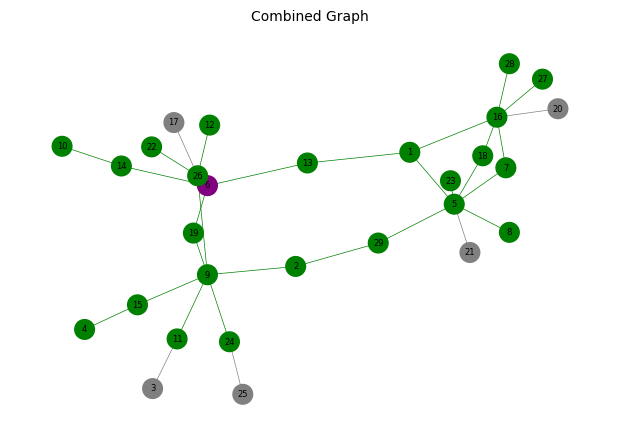

query is subgraph of source: True [0.983]


True

In [81]:
source_graph_idx = 0
query_subgraph_idx = 5

source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    #nodeLabels=graph_utils.get_node_labels( combined, **label_args )
)

is_subgraph( model, source, query )

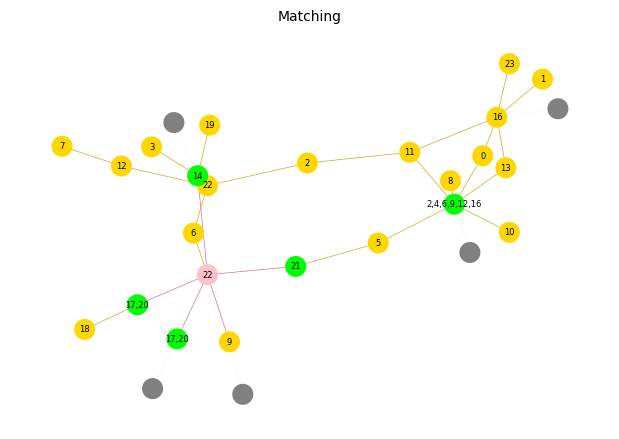

In [82]:
graph_utils.plot_interactions( args, model, source_graph_idx, query_subgraph_idx, threshold=0.5 )

In [83]:
source = graph_utils.load_source_graph( args, source_graph_idx, relabel=False )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx, relabel=False )
ground_truth = graph_utils.load_query_id_mapping( args, source_graph_idx, query_subgraph_idx, flip=False )

In [84]:
interactions = graph_utils.compute_interactions( model, source, query, threshold=0.5 )
interactions

{(14, 25): np.float32(0.91439956),
 (21, 1): np.float32(0.52118856),
 (22, 8): np.float32(0.62173724),
 (2, 4): np.float32(0.5433956),
 (4, 4): np.float32(0.51314783),
 (6, 4): np.float32(0.5297676),
 (9, 4): np.float32(0.53198653),
 (12, 4): np.float32(0.5408323),
 (16, 4): np.float32(0.5193537),
 (17, 10): np.float32(0.54528636),
 (20, 10): np.float32(0.5234766),
 (17, 14): np.float32(0.54528636),
 (20, 14): np.float32(0.5234766),
 (2, 15): np.float32(0.5035486),
 (12, 15): np.float32(0.50117326)}

In [85]:
query_nodes = set( sorted( query.nodes ) )
interaction_query_nodes = set( sorted( [ int( query ) for (query, source) in interactions.keys() ] ) )
print( "query nodes:", query_nodes, f"({len( query_nodes )})" )
print( "interaction query nodes:", interaction_query_nodes, f"({len( interaction_query_nodes )})" )

query nodes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} (24)
interaction query nodes: {2, 4, 6, 9, 12, 14, 16, 17, 20, 21, 22} (11)


In [86]:
source_nodes = set( sorted( source.nodes ) )
interaction_source_nodes = set( sorted( [ int( source ) for (query, source) in interactions.keys() ] ) )
print( "source nodes:", source_nodes, f"({len( source_nodes )})" )
print( "interaction source nodes:", interaction_source_nodes, f"({len( interaction_source_nodes )})" )

source nodes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28} (29)
interaction source nodes: {1, 4, 8, 10, 14, 15, 25} (7)


In [87]:
interaction_mappings = graph_utils.map_query_interactions( interactions, query )
interaction_mappings

{0: [],
 1: [],
 2: [4],
 3: [],
 4: [4],
 5: [],
 6: [4],
 7: [],
 8: [],
 9: [4],
 10: [],
 11: [],
 12: [4],
 13: [],
 14: [25],
 15: [],
 16: [4],
 17: [10, 14],
 18: [],
 19: [],
 20: [10, 14],
 21: [1],
 22: [8],
 23: []}

In [88]:
ground_truth

defaultdict(<function matching.glema.common.utils.graph_utils.read_mapping.<locals>.<lambda>()>,
            {17: 0,
             26: 1,
             12: 2,
             21: 3,
             4: 4,
             28: 5,
             18: 6,
             9: 7,
             22: 8,
             23: 9,
             7: 10,
             0: 11,
             13: 12,
             6: 13,
             25: 14,
             8: 15,
             15: 16,
             10: 17,
             3: 18,
             11: 19,
             14: 20,
             1: 21,
             5: 22,
             27: 23})